In [1]:
using CSV, Tables, LinearAlgebra, Random, Gurobi, JuMP, DataFrames, Statistics, MLJ, Plots, Clustering

In [2]:
# J = n of points
# I clusters
# D = dimension
# points[j,d]

### synthtic points

function generate_points(I,J,D, std; seed = 1234)
    Random.seed!(seed);
    X, yy = make_blobs(J, D; centers=I, cluster_std=std)
    points = Matrix(DataFrame(X));
    min = minimum(points, dims=1);
    max = maximum(points, dims=1);
    points = (points .- min) ./ (max .- min);
    return points
end

points = generate_points(3, 100, 2, [1, 2, 3]);

In [5]:
function manhattan_optimal_kmenas(points, I, J, D)
    
    model = JuMP.Model(Gurobi.Optimizer);

    @variable(model, gamma[1:J]);
    @variable(model, z[1:J, 1:I],Bin);
    @variable(model, mu[1:J, 1:I] >=0);
    @variable(model, r[1:J, 1:I] >=0);
    @variable(model, x[1:I, 1:D] >=0);
    @variable(model, y[1:J, 1:D, 1:I] >=0);

    @constraint(model, [j = 1:J], sum(z[j,:]) == 1);

    @constraint(model, [i=1:I, j=1:J, d=1:D], sum(y[j,d,i] for d=1:D) == r[j,i]);
    @constraint(model, [i=1:I, j=1:J, d=1:D], y[j,d,i] >= x[i,d] - points[j,d]);
    @constraint(model, [i=1:I, j=1:J, d=1:D], y[j,d,i] >= -(x[i,d] - points[j,d]));

    @constraint(model, [i=1:I, j=1:J], gamma[j]>= r[j,i]-mu[j,i]);

    @constraint(model, [i = 1:I, j = 1:J], 1000(1-z[j,i]) >= mu[j,i]);

    @objective(model, Min, sum(gamma[j] for j=1:J));

    optimize!(model);

    return value.(x), [argmax(value.(z)[i,:]) for i = 1:J], value.(gamma)  # centers, assignments, obj_value
end

function euclidean_optimal_kmenas(points,  I, J, D)
    
end

manhattan_optimal_kmenas (generic function with 1 method)

In [96]:
objective_value(model)

8.118575575371555

In [81]:
mapping = Dict(1=>:black, 0=>:red)

clusters = [mapping[v] for v in value.(z)[:,1]];

In [82]:
value.(x)

2×2 Matrix{Float64}:
 0.427146  0.206894
 0.709582  0.719582

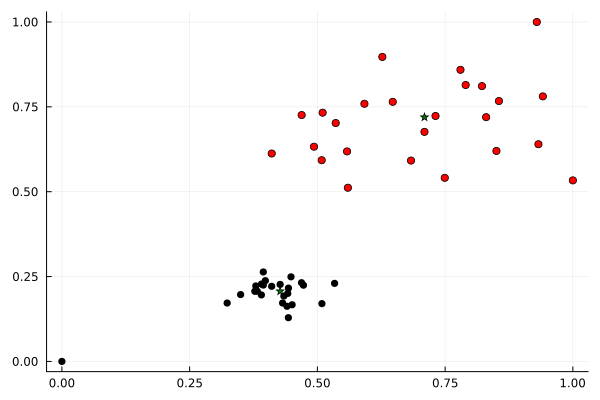

In [83]:
plot(points[:,1], points[:,2], seriestype=:scatter, legend=false, color=clusters)
plot!(value.(x)[:,1], value.(x)[:,2], seriestype=:scatter, legend=false, color=:green, markershape=:star5)

In [97]:
km = kmeans(points', 2, maxiter=2000);
mapping = Dict(1=>:black, 2=>:red)

clusters = [mapping[v] for v in km.assignments];

In [98]:
km.centers

2×2 Matrix{Float64}:
 0.405461  0.700689
 0.197954  0.705116

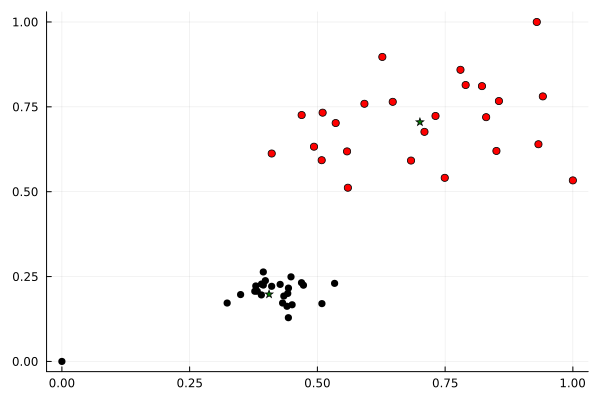

In [99]:
plot(points[:,1], points[:,2], seriestype=:scatter, legend=false, color=clusters)
plot!(km.centers[1,:], km.centers[2,:], seriestype=:scatter, legend=false, color=:green, markershape=:star5)

### Try using euclidean distances

In [14]:
# J = n of points
# I clusters
# D = dimension
# points[j,d]

### synthtic points
J = 100;
I = 3;
D = 2;

Random.seed!(1234)
X, yy = make_blobs(J, D; centers=I, cluster_std=[1, 1, 1])
points = Matrix(DataFrame(X));

min = minimum(points, dims=1);
max = maximum(points, dims=1);

points = (points .- min) ./ (max .- min);

In [18]:
### euclidean distance

model = JuMP.Model(Gurobi.Optimizer);

@variable(model, gamma[1:J]);
@variable(model, z[1:J, 1:I],Bin);
@variable(model, mu[1:J, 1:I] >=0);
@variable(model, r[1:J, 1:I] >=0);
@variable(model, x[1:I, 1:D] >=0);
@variable(model, y[1:J, 1:D, 1:I] >=0);

@constraint(model, [j = 1:J], sum(z[j,:]) == 1);

@constraint(model, [i=1:I, j=1:J, d=1:D], sum(y[j,d,i] for d=1:D) == r[j,i]);
@constraint(model, [i=1:I, j=1:J, d=1:D], y[j,d,i] >= (x[i,d] - points[j,d])^2);
#@constraint(model, [i=1:I, j=1:J, d=1:D], y[j,d,i] >= -(x[i,d] - points[j,d]));

@constraint(model, [i=1:I, j=1:J], gamma[j]>= r[j,i]-mu[j,i]);

@constraint(model, [i = 1:I, j = 1:J], 1000(1-z[j,i]) >= mu[j,i]);

@objective(model, Min, sum(gamma[j] for j=1:J));

optimize!(model);

Set parameter Username
Academic license - for non-commercial use only - expires 2023-10-04
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1300 rows, 1606 columns and 3600 nonzeros
Model fingerprint: 0xeb3a7077
Model has 600 quadratic constraints
Variable types: 1306 continuous, 300 integer (300 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [6e-02, 2e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+03]
  QRHS range       [8e-04, 1e+00]
Presolve removed 406 rows and 700 columns
Presolve time: 0.01s
Presolved: 894 rows, 906 columns, 3282 nonzeros
Presolved model has 6 quadratic constraint(s)
Variable types: 606 continuous, 300 integer (300 binary)

Root relaxation: objective -6.666667e+04, 312 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    

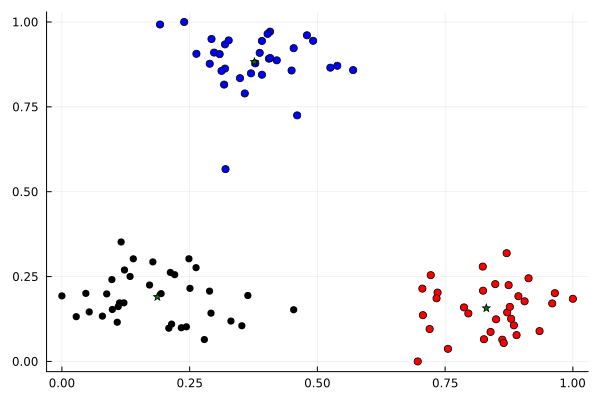

In [16]:
assignments = [argmax(value.(z)[i,:]) for i = 1:J];
mapping = Dict(1=>:black, 2=>:red, 3=>:blue)
clusters = [mapping[v] for v in assignments];

plot(points[:,1], points[:,2], seriestype=:scatter, legend=false, color=clusters)
plot!(value.(x)[:,1], value.(x)[:,2], seriestype=:scatter, legend=false, color=:green, markershape=:star5)

In [156]:
#### manhattan
model = JuMP.Model(Gurobi.Optimizer);

@variable(model, gamma[1:J]);
@variable(model, z[1:J, 1:I],Bin);
@variable(model, mu[1:J, 1:I] >=0);
@variable(model, r[1:J, 1:I] >=0);
@variable(model, x[1:I, 1:D] >=0);
@variable(model, y[1:J, 1:D, 1:I] >=0);

@constraint(model, [j = 1:J], sum(z[j,:]) == 1);

@constraint(model, [i=1:I, j=1:J, d=1:D], sum(y[j,d,i] for d=1:D) == r[j,i]);
@constraint(model, [i=1:I, j=1:J, d=1:D], y[j,d,i] >= x[i,d] - points[j,d]);
@constraint(model, [i=1:I, j=1:J, d=1:D], y[j,d,i] >= -(x[i,d] - points[j,d]));

@constraint(model, [i=1:I, j=1:J], gamma[j]>= r[j,i]-mu[j,i]);

@constraint(model, [i = 1:I, j = 1:J], 1000(1-z[j,i]) >= mu[j,i]);

@objective(model, Min, sum(gamma[j] for j=1:J));

optimize!(model);

Set parameter Username
Academic license - for non-commercial use only - expires 2023-10-04
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 2500 rows, 1606 columns and 6000 nonzeros
Model fingerprint: 0x1a549cc6
Variable types: 1306 continuous, 300 integer (300 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+03]
Presolve removed 924 rows and 612 columns
Presolve time: 0.01s
Presolved: 1576 rows, 994 columns, 3852 nonzeros
Variable types: 694 continuous, 300 integer (300 binary)
Found heuristic solution: objective 34.0761583

Root relaxation: objective -6.115403e+01, 1013 iterations, 0.01 seconds (0.02 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

  

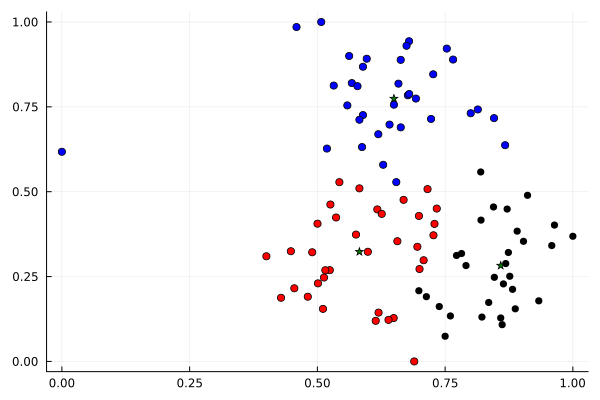

In [157]:
assignments = [argmax(value.(z)[i,:]) for i = 1:J];
mapping = Dict(1=>:black, 2=>:red, 3=>:blue)
clusters = [mapping[v] for v in assignments];

plot(points[:,1], points[:,2], seriestype=:scatter, legend=false, color=clusters)
plot!(value.(x)[:,1], value.(x)[:,2], seriestype=:scatter, legend=false, color=:green, markershape=:star5)

In [158]:
idx_1 = findall(x->x==1, assignments);
idx_2 = findall(x->x==2, assignments);
idx_3 = findall(x->x==3, assignments);

cluster1 = points[idx_1,:];
cluster2 = points[idx_2,:];
cluster3 = points[idx_3,:];

In [159]:
sum((cluster1[j] - cluster2[k])^2 for j=1:size(cluster1)[1], k=1:size(cluster2)[1])^(0.5) + 
sum((cluster1[j] - cluster3[k])^2 for j=1:size(cluster1)[1], k=1:size(cluster3)[1])^(0.5) + 
sum((cluster2[j] - cluster3[k])^2 for j=1:size(cluster2)[1], k=1:size(cluster3)[1])^(0.5)

24.140421655047362

In [160]:
## kmeans
km = kmeans(points', 3);
assignments = km.assignments;

idx_1 = findall(x->x==1, assignments);
idx_2 = findall(x->x==2, assignments);
idx_3 = findall(x->x==3, assignments);

cluster1 = points[idx_1,:];
cluster2 = points[idx_2,:];
cluster3 = points[idx_3,:];

sum((cluster1[j] - cluster2[k])^2 for j=1:size(cluster1)[1], k=1:size(cluster2)[1])^(0.5) + 
sum((cluster1[j] - cluster3[k])^2 for j=1:size(cluster1)[1], k=1:size(cluster3)[1])^(0.5) + 
sum((cluster2[j] - cluster3[k])^2 for j=1:size(cluster2)[1], k=1:size(cluster3)[1])^(0.5)

24.195025091639838